In [19]:
# python packages pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import inspect

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional, Activation
from keras.layers import CuDNNLSTM
from keras.utils.np_utils import to_categorical
# from keras.callbacks import EarlyStopping
from keras.layers import Dropout

from sklearn.model_selection import train_test_split
import importlib
import utilis

# custom
from keras.constraints import MinMaxNorm

from keras import backend as K
from keras.layers import Layer
from keras import initializers, regularizers, constraints, Input
from keras.models import Model

In [2]:
sys.path.append("..")

In [3]:
# custom python scripts
from packages import generator

In [4]:
importlib.reload(generator)

<module 'packages.generator' from '../packages/generator.py'>

In [5]:
# # check version
# print(inspect.getsource(generator.Keras_DataGenerator))

# Bidirectional LSTM with Hypotheses

In [6]:
# Check that you are running GPU's
utilis.GPU_checker()





You are runnning an instance with 4 GPU's


In [7]:
utilis.aws_setup()

AWS SETUP SHOULD BE COMPLETE, we are on <botocore.client.S3 object at 0x7f3d483fd940>


# Config, generators and train

In [8]:
INPUT_TENSOR_NAME = "inputs_input"
SIGNATURE_NAME = "serving_default"
W_HYP = False
# LEARNING_RATE = 0.001
BATCH_SIZE = 64

# constnats
VOCAB_SIZE = 1254
INPUT_LENGTH = 3000 if W_HYP else 1000
EMBEDDING_DIM = 512

print(INPUT_LENGTH)

1000


In [16]:
importlib.reload(generator)

# generators
training_generator = generator.Keras_DataGenerator(data_dir='', subset_frac = 0.04,  dataset='train_new', w_hyp=W_HYP)
print()
validation_generator = generator.Keras_DataGenerator(data_dir='', subset_frac = 0.04,  dataset='valid_new', w_hyp=W_HYP)

# of batches:  5888.0
# of batches reduced to:  235.52
Generating examples from a set of 15073.28 examples 


# of batches:  1600.0
# of batches reduced to:  64.0
Generating examples from a set of 4096.0 examples 



In [34]:
# custom dot product function
def dot_product(x, kernel):
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    
# find a way to return attention weight vector a
class AttentionWithContext(Layer):
    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        # initialization of all learnable params
        self.init = initializers.get('lecun_uniform')
        
        # regularizers for params, init as None
        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        
        # constraints for params, init as None
        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
#         assert len(input_shape) == 3
        
        # weight matrix
        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        # bias term
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='lecun_uniform',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        
        # context vector
        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)
        
    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)
        
        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
#         a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon()* 100, K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]  

    
# model
def build_model(vocab_size, embedding_dim, input_length):
    sequence_input = Input(shape=(input_length,), dtype='int32')
    embedded_sequences = Embedding(vocab_size, embedding_dim, input_length=input_length)(sequence_input)
    output_1 = SpatialDropout1D(0.9)(embedded_sequences)
    output1 = Dropout(0.9)(output_1)
    output_2 = Bidirectional(CuDNNLSTM(512, return_sequences=True, 
                                       kernel_constraint=MinMaxNorm(min_value=0.0001, max_value=1.0, rate=1.0, axis=0), 
                                       recurrent_constraint=MinMaxNorm(min_value=0.0001, max_value=1.0, rate=1.0, axis=0), 
                                       bias_constraint = MinMaxNorm(min_value=0.0001, max_value=1.0, rate=1.0, axis=0)))(output_1)
    context_vec = AttentionWithContext(
        W_constraint = MinMaxNorm(min_value=0.0001, max_value=1.0, rate=1.0, axis=0),
        u_constraint = MinMaxNorm(min_value=0.0001, max_value=1.0, rate=1.0, axis=0),
        b_constraint = MinMaxNorm(min_value=0.0001, max_value=1.0, rate=1.0, axis=0))(output_2)
    
    context_vec = Dropout(0.9)(context_vec)
    predictions = Dense(41, kernel_constraint = MinMaxNorm(min_value=0.0001, max_value=1.0, rate=1.0, axis=0), activation='softmax')(context_vec)
    model = Model(inputs=sequence_input, outputs=predictions)
    return model

### testing generator

In [37]:
model = build_model(VOCAB_SIZE, EMBEDDING_DIM, INPUT_LENGTH)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 1000, 512)         642048    
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 1000, 512)         0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 1000, 1024)        4202496   
_________________________________________________________________
attention_with_context_6 (At (None, 1024)              1050624   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 41)                42025     
Total para

In [12]:
## ARE YOU LOADING A MODEL IF YES RUN TEH FOLLOWING LINES 
# from keras.models import model_from_json
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")
# # REMEMEBER TO COMPILE 
# loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
#overwriting model
# model = loaded_model

In [14]:
# model.layers[4].get_weights()

In [ ]:
%%time
#try and make it run until 9 am GMT+1
n_epochs = 22
history = model.fit_generator(generator=training_generator,
                            validation_data=validation_generator,
                            verbose=1,
                            use_multiprocessing=False,
                            epochs=n_epochs)

Epoch 1/22
235/235 [==============================] - 234s 998ms/step - loss: 2.8469 - acc: 0.1542 - val_loss: 2.7056 - val_acc: 0.1904
Epoch 2/22
235/235 [==============================] - 333s 1s/step - loss: 2.7212 - acc: 0.1751 - val_loss: 2.5501 - val_acc: 0.1968
Epoch 3/22
235/235 [==============================] - 229s 976ms/step - loss: 2.5725 - acc: 0.2205 - val_loss: 2.5090 - val_acc: 0.2021
Epoch 4/22
235/235 [==============================] - 229s 973ms/step - loss: 2.4730 - acc: 0.2459 - val_loss: 2.3773 - val_acc: 0.2703
Epoch 5/22
235/235 [==============================] - 224s 953ms/step - loss: 2.3971 - acc: 0.2696 - val_loss: 2.2765 - val_acc: 0.2930
Epoch 6/22
235/235 [==============================] - 226s 962ms/step - loss: 2.2934 - acc: 0.2878 - val_loss: 2.1951 - val_acc: 0.3088
Epoch 7/22
235/235 [==============================] - 227s 966ms/step - loss: 2.2386 - acc: 0.2894 - val_loss: 2.1775 - val_acc: 0.2988
Epoch 8/22
235/235 [==============================]

KeyboardInterrupt: 

## Save modek

In [42]:
# FOR SAVING MODEL
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [43]:
#WARNING_DECIDE_HOW_TO_NAME_LOG
#descriptionofmodel_personwhostartsrun
#e.g. LSTM_128encoder_etc_tanc
LOSS_FILE_NAME = "recs_1"

#WARNING NUMBER 2 - CURRENTLY EVERYTIME YOU RERUN THE CELLS BELOW THE FILES WITH THOSE NAMES GET WRITTEN OVER

In [44]:
# save history - WARNING FILE NAME 
utilis.history_saver_bad(history, LOSS_FILE_NAME)

SAVED SOME LOGS -- OVERWROTE OLD LOGS -- SOMEONE NEEDS TO FIX THIS


In [39]:
test_generator = generator.Keras_DataGenerator(data_dir='', subset_frac=0.01,  dataset='test_new', w_hyp=W_HYP)
model.evaluate_generator(test_generator, verbose =1)

# of batches:  1920.0
# of batches reduced to:  19.2
Generating examples from a set of 1228.8 examples 

19/19 [==============================] - 17s 914ms/step


[2.0523844204450907, 0.31085526315789475]

In [40]:
scores = model.predict_generator(test_generator)

In [41]:
medians = np.mean(scores, axis = 0)

In [54]:
medians.shape, np.array(lis).shape

((41,), (40,))

Text(0.5, 1.0, 'Distribution of Labels - Attention G')

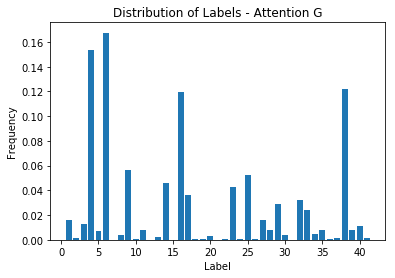

In [58]:
plt.bar(lis, medians)
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.title("Distribution of Labels - Attention G")

In [55]:
lis  = [x for x in range(1,42)]

In [56]:
lis

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41]